In [1]:
import os
import urllib

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import requests
import warnings

from fred import *

warnings.simplefilter(action='ignore')

# What are we looking for?

Housing real estate is a market driven by several factors, including supply and demand. High supply and low demand drive market prices lower. Conversely, low supply and high demand drive market prices higher.

**The amount of housing available weighs the supply side of the market equation.** The following attributes positively impact home prices, or are correlated with high home prices:
* low (< 5%) and/or declining vacancy rates (higher buyer competition for available homes)
* low number of new building permits (less supply in the future)
* low land area available for real estate development
* low inventory of homes for sale
* low amount of time a property stays on the market
* high rental costs compared to home ownership costs


Increasing number of listings (agreement between owner and real estate agent) is a sign for a peak in home prices, as owners and investors seek capital gains. Conversely, decreasing number of listings usually signals higher future home prices.



# Results

## House price index

In [2]:
house_price_df = pd.DataFrame(columns=["date", "geography", "price_index"])

In [3]:
payload = {
    "series_id": "ATNHPIUS26065A",
    "api_key": FRED_API_KEY,
    "file_type": "json"
}
response = requests.get(FRED_SERIES_FULL_URL, params=payload)

In [4]:
for obs in response.json()["observations"]:
    house_price_df = house_price_df.append({
        "date": obs["date"],
        "geography": "Ingham County",
        "price_index": float(obs["value"])
    }, ignore_index=True)

In [5]:
payload = {
    "series_id": "MISTHPI",
    "api_key": FRED_API_KEY,
    "file_type": "json"
}
response = requests.get(FRED_SERIES_FULL_URL, params=payload)

In [6]:
for obs in response.json()["observations"]:
    house_price_df = house_price_df.append({
        "date": obs["date"],
        "geography": "Michigan",
        "price_index": float(obs["value"])
    }, ignore_index=True)

In [7]:
payload = {
    "series_id": "USSTHPI",
    "api_key": FRED_API_KEY,
    "file_type": "json"
}
response = requests.get(FRED_SERIES_FULL_URL, params=payload)

In [8]:
for obs in response.json()["observations"]:
    house_price_df = house_price_df.append({
        "date": obs["date"],
        "geography": "USA",
        "price_index":float(obs["value"])
    }, ignore_index=True)

In [9]:
house_price_df.loc[:, "date"] = pd.to_datetime(house_price_df["date"])

In [10]:
usa_all = house_price_df[(house_price_df["geography"]=="USA")]
usa_all["price_index_norm"] = usa_all["price_index"].apply(
    lambda x: x / usa_all[usa_all["date"]=="2000-01-01"]["price_index"]*100
)

In [11]:
michigan_all = house_price_df[(house_price_df["geography"]=="Michigan")]
michigan_all["price_index_norm"] = michigan_all["price_index"].apply(
    lambda x: x / michigan_all[michigan_all["date"]=="2000-01-01"]["price_index"]*100
)

In [12]:
ingham_all = house_price_df[(house_price_df["geography"]=="Ingham County")]
ingham_all["price_index_norm"] = ingham_all["price_index"].apply(
    lambda x: x / ingham_all[ingham_all["date"]=="2000-01-01"]["price_index"]*100
)

In [13]:
date_mask = (house_price_df["date"] >= "1990-01-01")
usa = usa_all[date_mask]
michigan = michigan_all[date_mask]
ingham = ingham_all[date_mask]

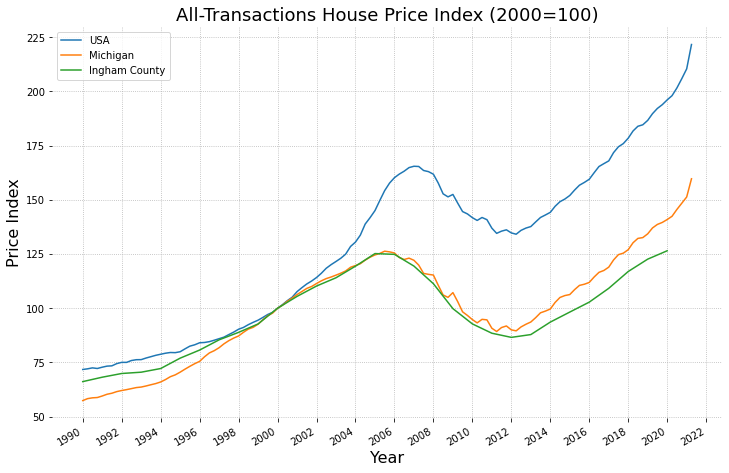

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(usa["date"], usa["price_index_norm"], label="USA")
ax.plot(michigan["date"], michigan["price_index_norm"], label="Michigan")
ax.plot(ingham["date"], ingham["price_index_norm"], label="Ingham County")
ax.set_title("All-Transactions House Price Index (2000=100)", fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Price Index", fontsize=16)
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
plt.legend();

Home prices have consistently increased since 2012, following the recovery of the 2007 financial crisis. Compared to Michigan and the US, the increase of the house price index in Ingham County has been slower, especially between 2018 and 2020. While the index has largely overshot its 2006 peak in the US and in Michigan as a whole, the index just reached its 2006 peak in 2020 in Ingham County.

## Median listing price per square feet

In [15]:
dtypes = {"date": "date", "value": "float"}

In [16]:
ingham_price_sqft = parse_fred(download_fred("MEDLISPRIPERSQUFEE26065"), dtypes=dtypes)

In [17]:
usa_price_sqft = parse_fred(download_fred("MEDLISPRIPERSQUFEEUS"), dtypes=dtypes)

In [18]:
michigan_price_sqft = parse_fred(download_fred("MEDLISPRIPERSQUFEEMI"), dtypes=dtypes)

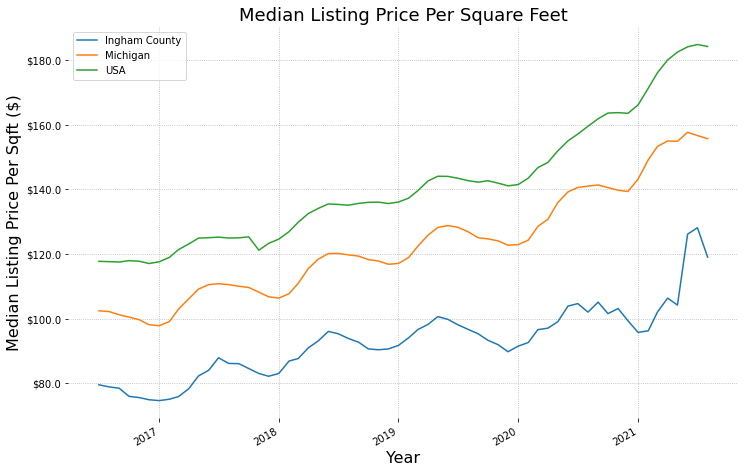

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ingham_price_sqft["date"], ingham_price_sqft["value"], label="Ingham County")
ax.plot(michigan_price_sqft["date"], michigan_price_sqft["value"], label="Michigan")
ax.plot(usa_price_sqft["date"], usa_price_sqft["value"], label="USA")
ax.set_title("Median Listing Price Per Square Feet", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Median Listing Price Per Sqft ($)", fontsize=16)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("${x}"))
fig.autofmt_xdate()
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
plt.legend();

Across all three geographies, the median listing price per square feet has gradually increased since 2017. We can see seasonal variations, with summer prices being higher than winter prices. Prices showed a sharp jump up in 2021. Past the mid-2021 mark, the price has stabilized in the US and Michigan, and decreased but remained high in Ingham County.

## Median listing price

In [20]:
ingham_price = parse_fred(download_fred("MEDLISPRI26065"), dtypes=dtypes)
michigan_price = parse_fred(download_fred("MEDLISPRIMI"), dtypes=dtypes)
usa_price = parse_fred(download_fred("MEDLISPRIUS"), dtypes=dtypes)

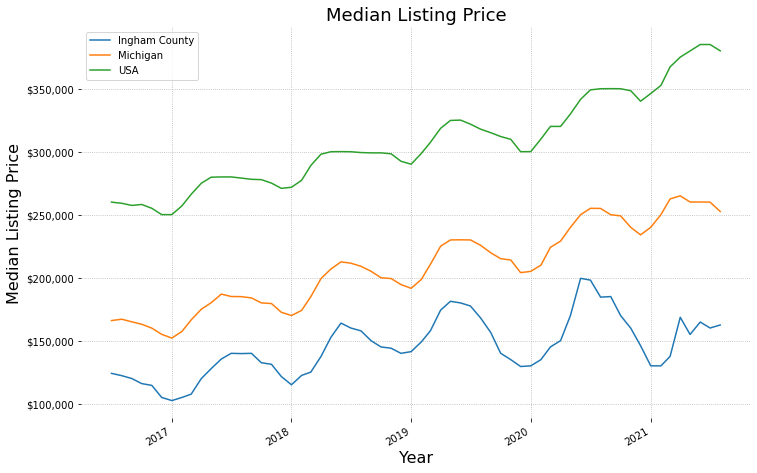

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ingham_price["date"], ingham_price["value"], label="Ingham County")
ax.plot(michigan_price["date"], michigan_price["value"], label="Michigan")
ax.plot(usa_price["date"], usa_price["value"], label="USA")
ax.set_title("Median Listing Price", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Median Listing Price", fontsize=16)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("${x:,g}"))
fig.autofmt_xdate()
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
plt.legend();

The median listing price has gradually increased in all geographies since 2017. However, Ingham County prices 2021 summer prices have stabilized below summer prices seen in previous years. Taking into account the increase in price per square feet shown in the previous figure, this suggests that 2021 listings have a smaller surface on average than listings for previous years.

## Building permits for new private housing structures

In [22]:
ingham_permits = parse_fred(download_fred("BPPRIV026065"), dtypes=dtypes)
michigan_permits = parse_fred(download_fred("MIBPPRIVSA"), dtypes=dtypes)

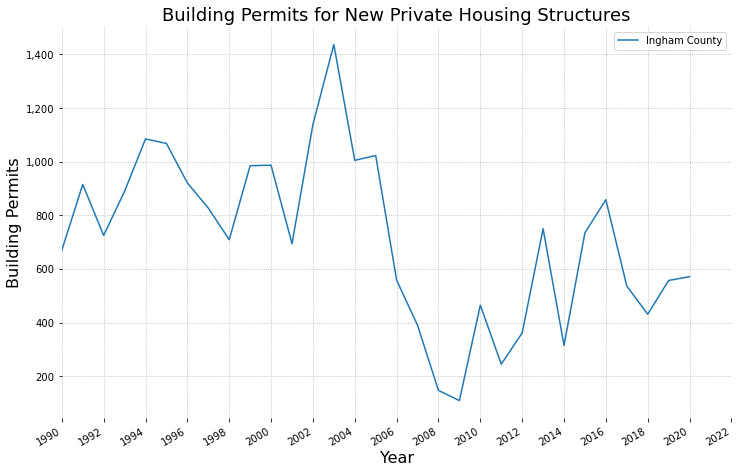

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ingham_permits["date"], ingham_permits["value"], label="Ingham County")
ax.set_title("Building Permits for New Private Housing Structures", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_xlim("1990-01-01", "2022-01-01")
ax.set_ylabel("Building Permits", fontsize=16)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
fig.autofmt_xdate()
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
plt.legend();

Following the 2007 financial crisis and its large surplus of homes for sale and new building permits, building permits reached a low in 2009 and then increased during the last decade. Since 2018, the growth of building permits appears to have slowed down. In any case, we are still largely below levels seen in the 1990's and early 2000's.

## Total listing count

In [24]:
ingham_count = parse_fred(download_fred("TOTLISCOU26065"), dtypes=dtypes)

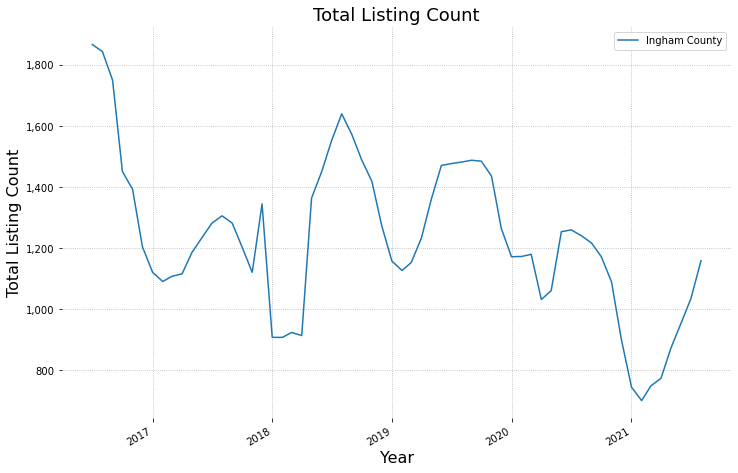

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ingham_count["date"], ingham_count["value"], label="Ingham County")
ax.set_title("Total Listing Count", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Total Listing Count", fontsize=16)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
fig.autofmt_xdate()
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
plt.legend();

The total listing count has been decreasing since 2016, and 2021 levels are the lowest of the past five years, indicating that the market of homes for sale is getting tighter.

## Median days on the market

In [26]:
ingham_days_market = parse_fred(download_fred("MEDDAYONMAR26065"), dtypes=dtypes)
us_days_market = parse_fred(download_fred("MEDDAYONMARUS"), dtypes=dtypes)
michigan_days_market = parse_fred(download_fred("MEDDAYONMARMI"), dtypes=dtypes)

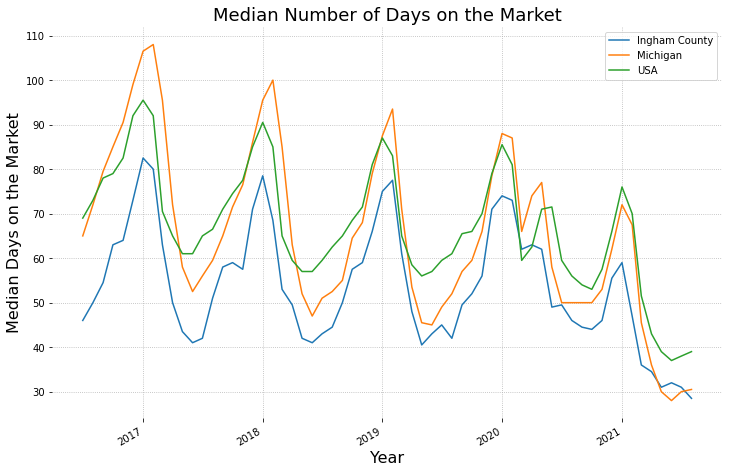

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ingham_days_market["date"], ingham_days_market["value"], label="Ingham County")
ax.plot(michigan_days_market["date"], michigan_days_market["value"], label="Michigan")
ax.plot(us_days_market["date"], us_days_market["value"], label="USA")
ax.set_title("Median Number of Days on the Market", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Median Days on the Market", fontsize=16)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
fig.autofmt_xdate()
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
plt.legend();

The median number of days on the market show large seasonal variations. Consistent with previous figures, the summer home market is much more dynamic than the winter market. During summer 2021, homes for sale in Ingham County stayed on the market for about a month. Similar numbers can be seen for Michigan. Ingham County and Michigan markets are more dynamic than the US as a whole, where homes stayed on the market for about 40 days.

## Vacancy rates

In [28]:
us_rent_vac = parse_fred(download_fred("RRVRUSQ156N"), dtypes=dtypes)
michigan_rent_vac = parse_fred(download_fred("MIRVAC"), dtypes=dtypes)
us_own_vac = parse_fred(download_fred("RHVRUSQ156N"), dtypes=dtypes)
michigan_own_vac = parse_fred(download_fred("MIHVAC"), dtypes=dtypes)

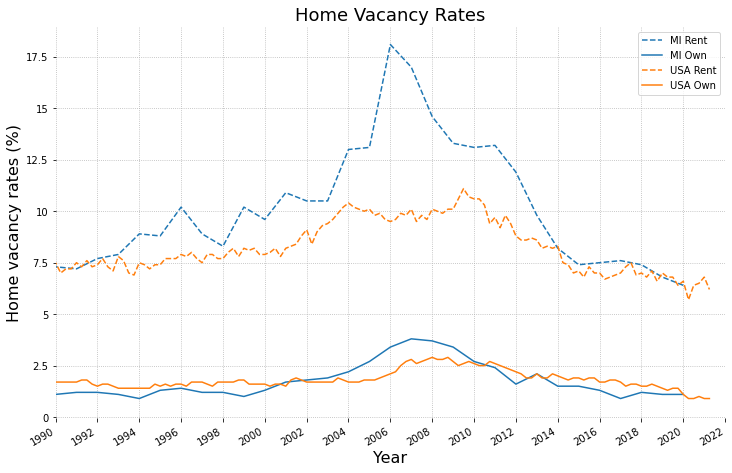

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(michigan_rent_vac["date"], michigan_rent_vac["value"], color="C0", linestyle="--", label="MI Rent")
ax.plot(michigan_own_vac["date"], michigan_own_vac["value"], color="C0", linestyle="-", label="MI Own")
ax.plot(us_rent_vac["date"], us_rent_vac["value"], color="C1", linestyle="--", label="USA Rent")
ax.plot(us_own_vac["date"], us_own_vac["value"], color="C1", linestyle="-", label="USA Own")
ax.set_title("Home Vacancy Rates", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_xlim("1990-01-01", "2022-01-01")
ax.set_ylabel("Home vacancy rates (%)", fontsize=16)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
fig.autofmt_xdate()
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
plt.legend();

Vacancy rates for both rental and owned properties are at their lowest point since 1990, both in Michigan and in the US. This is consistent with the low listing count and permits for new buildings.

## Price reduced count

In [30]:
ingham_price_reduced = parse_fred(download_fred("PRIREDCOU26065"), dtypes=dtypes)

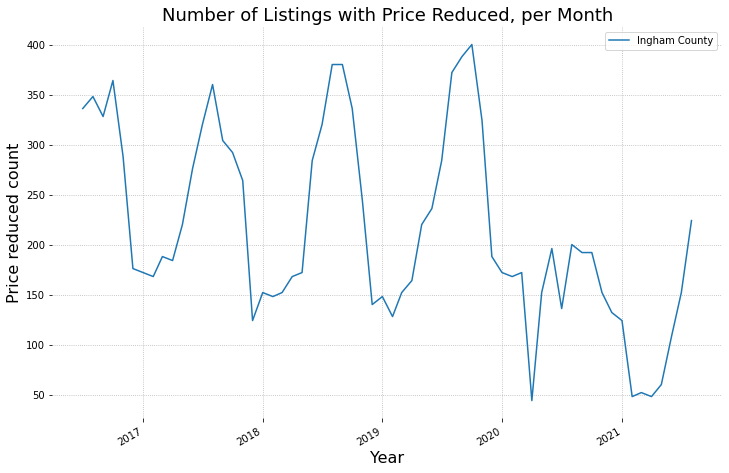

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ingham_price_reduced["date"], ingham_price_reduced["value"], label="Ingham County")
ax.set_title("Number of Listings with Price Reduced, per Month", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Price reduced count", fontsize=16)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
fig.autofmt_xdate()
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
plt.legend();

The count of listings which have had their price reduced during the month. The number of listings with prices reduced was at its lowest point since 2016 in 2020 and 2021. This suggests that home sellers have more power than buyers when it comes to negotiate home prices. Again, this is consistent with the tight home inventory that is currently seen.

## Market hotness score

The Hotness score is an equally-weighted composite metric of a market's supply score (based on days on market) and demand score (based on realtor.com listing views).

Realtor.com, Market Hotness: Hotness Score in Ingham County, MI [HOSCCOUNTY26065], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/HOSCCOUNTY26065, June 19, 2021.

More info can be found at https://www.realtor.com/research/reports/hottest-markets/.

In [32]:
ingham_market_hotness = parse_fred(download_fred("HOSCCOUNTY26065"), dtypes=dtypes)

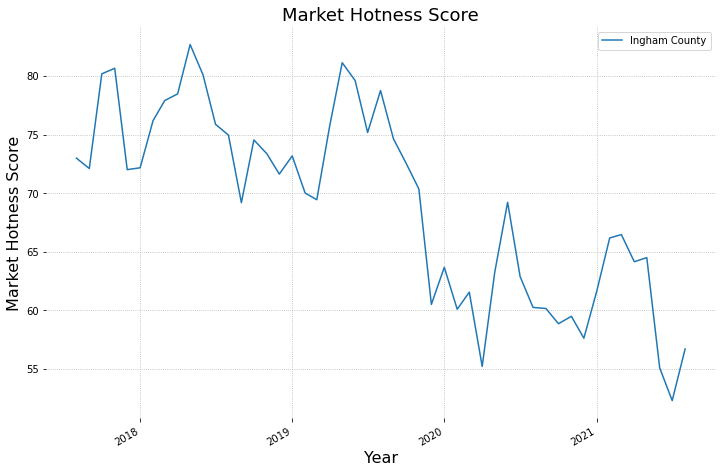

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ingham_market_hotness["date"], ingham_market_hotness["value"], label="Ingham County")
ax.set_title("Market Hotness Score", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Market Hotness Score", fontsize=16)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,g}"))
fig.autofmt_xdate()
for side in ("top", "bottom", "left", "right"):
    ax.spines[side].set_visible(False)
ax.grid(linestyle=":")
plt.legend();

The market hotness score has varied between around 65 and 55 in Ingham County, in 2021. These numbers characterize a fairly hot market (the Lansing-East Lansing MSA ranks 74th out of 300), consistent with previous figures showing low median number of days on the market.

Interestingly, the market hotness score has consistently decreased since 2017. Coupled with previous figures showing high home prices, a tight inventory, and an increasing number of new building permits, this may signal that home prices will decrease in the long term.

## Summary

Overall, most indicators are consistent with high home prices, a tight inventory, and a very hot market biased towards the benefits of home sellers. Although it seems that home prices will remain high in the short term, a few clues hint at lower prices over the longer term: home prices close to their historical peak, an increasing number of new building permits, and a market hotness that appears to gradually fade.

| Data                                            | Value | Evolution | Impact on/correlation with prices |
|-------------------------------------------------|-------|-----------|-----------------------------------|
| Rental vacancy rate                             |    Low| Decreasing|                                  +|
| Homeowner vacancy rate                          |    Low| Decreasing|                                  +|
| Number of new building permits for housing      | Medium| Increasing|                                  -|
| Land area available for real estate development |      ?|          ?|                                  ?|
| Inventory of homes for sale                     |    Low| Decreasing|                                  +|
| Amount of time on the market                    |    Low| Decreasing|                                  +|
| Rental costs compared to home ownership costs   |   High|          ?|                                  +|
| Number of homes where price was reduced         |    Low| Decreasing|                                  +|